In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import random
import json  # for storing arrays as strings

# -----------------------------
# User settings
# -----------------------------
patient_id = 4                     # change to the patient you want (1..12)
patient_folder = f"Patient{patient_id}"
cluster_pattern = "cluster{}.csv"  # cluster1.csv ... cluster15.csv
n_clusters_expected = 15

n_samples = 6000

# timepoint names (must match columns order in CSVs)
timepoint_names = [
    'Before Surgery', '5 Minutes', '30 Minutes', '60 Minutes',
    '120 Minutes', '1 Day', '2 Days', '3 Days',
    '4 Days', '10 Days', '3 Months', '6 Months', '1 Year'
]

T = len(timepoint_names)

# -----------------------------
# Load all clusters into memory
# -----------------------------
clusters = []

for c in range(1, n_clusters_expected + 1):
    fname = os.path.join(patient_folder, cluster_pattern.format(c))
    if not os.path.exists(fname):
        raise FileNotFoundError(f"Missing: {fname}")

    df = pd.read_csv(fname, header=None)
    clusters.append(df)

print(f"Loaded {len(clusters)} clusters.")

# -----------------------------
# Utility to fix strings like '[[1.02]]' -> 1.02
# -----------------------------
def clean_float(x):
    x = str(x).replace("[", "").replace("]", "")
    return float(x)

# -----------------------------
# Function: sample 1 random gene per cluster
# -----------------------------
def sample_one_panel():
    gene_matrix = np.zeros((n_clusters_expected, T))
    gene_names = []

    for ci, df in enumerate(clusters):
        row_idx = random.randrange(df.shape[0])
        row = df.iloc[row_idx, :].values
        gene_names.append(str(row[0]))

        expr_vals = np.array([clean_float(v) for v in row[1:1+T]], dtype=float)
        gene_matrix[ci, :] = expr_vals

    return gene_matrix, gene_names

# -----------------------------
# Generate N samples
# -----------------------------
all_samples = np.zeros((n_samples, n_clusters_expected, T))

gene_name_list = []  # keep names if needed

for i in range(n_samples):
    mat, names = sample_one_panel()
    all_samples[i] = mat
    gene_name_list.append(names)

print("Generated sample matrix shape:", all_samples.shape)
# shape → (1000, 15, 13)

# Prepare expression rows
expr_rows = []

for c in range(n_clusters_expected):
    # all_samples[:, c, :] → shape (n_samples, T)
    # transpose to (T, n_samples) to match Drosophila row-per-timepoint
    expr_block = all_samples[:, c, :].T  # shape: (T, n_samples)
    expr_rows.extend(expr_block)          # append T rows per cluster

# Convert to DataFrame
expr_df = pd.DataFrame(expr_rows)

# Add column names for samples
expr_df.columns = [f"Sample_{i+1}" for i in range(n_samples)]

# Save CSV
csv_fname = f"liver_data_for_dsrn_patient{patient_id}.csv"
expr_df.to_csv(csv_fname, index=False)
print("Saved liver DSRN CSV:", expr_df.shape)


Loaded 15 clusters.
Generated sample matrix shape: (6000, 15, 13)
Saved liver DSRN CSV: (195, 6000)


In [2]:
#============================================================
# DSRN for Liver Regeneration Gene Expression Prediction
# Predict next timepoint from previous timepoint
#============================================================

# =====================================================
# LOAD Data
# =====================================================
file = f"liver_data_for_dsrn_patient{patient_id}.csv"
df = pd.read_csv(file)

print("Loaded:", df.shape)

# -----------------------------------------------------
# Extract timepoint rows only
# First 4 rows = coordinates
# Then 6 rows per gene
# -----------------------------------------------------
expr = df.iloc[:, :].values       # shape (13*num_genes/clusters, num_samples)

num_cells = expr.shape[1]
num_genes = expr.shape[0] // T

print("Genes/clusters:", num_genes)
print("Samples:", num_cells)

# =====================================================
# Define transitions of interest
# =====================================================
transitions_of_interest = [
    ('5 Minutes', '1 Day'),
    ('1 Day', '3 Months')
]

# Map timepoint names to indices
timepoint_to_idx = {name: i for i, name in enumerate(timepoint_names)}

# =====================================================
# FORM INPUT → OUTPUT PAIRS FOR SELECTED TRANSITIONS
# =====================================================
X = []
Y = []

for g in range(num_genes):
    block = expr[g*T:(g+1)*T, :]    # shape (T, num_cells)

    for from_name, to_name in transitions_of_interest:
        t_from = timepoint_to_idx[from_name]
        t_to   = timepoint_to_idx[to_name]

        X.append(block[t_from, :])
        Y.append(block[t_to, :])

X = np.array(X)  # (num_genes * num_transitions, num_cells)
Y = np.array(Y)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

# ============ COMPUTE ENTROPY ==============
def compute_topological_entropy(trajectory, eps_values):
    entropy_estimates = {}
    for eps in eps_values:
        unique_orbits = set()
        for point in trajectory:
            rounded_point = tuple(np.round(point / eps))  
            unique_orbits.add(rounded_point)
        N_n_eps = len(unique_orbits)
        entropy_estimates[eps] = np.log(N_n_eps) / len(trajectory)  
    return entropy_estimates

# =====================================================
# LORENZ SYSTEM FOR RESERVOIR
# =====================================================
def lorenz_system(t, X, params, N):
    X = X.reshape(N, 3)
    dxdt = params[:,0] * (X[:,1] - X[:,0]) / params[:,3]
    dydt = (X[:,0]*(params[:,1]-X[:,2]) - X[:,1]) / params[:,3]
    dzdt = (X[:,0]*X[:,1] - params[:,2]*X[:,2]) / params[:,3]
    return np.stack([dxdt, dydt, dzdt], axis=1).flatten()
    

Loaded: (195, 6000)
Genes/clusters: 15
Samples: 6000
X shape: (30, 6000)
Y shape: (30, 6000)


In [3]:
seed_list = [46, 2, 10, 100, 80, 20, 60]

for random_seed in seed_list:
    print(f"======================")
    print(f"Running experiment for seed = {random_seed}")
    
    np.random.seed(random_seed)
    random.seed(random_seed)

    # =====================================================
    # TRAIN / TEST SPLIT — 80% cells train, 20% test
    # =====================================================
    cells = np.arange(num_cells)
    train_idx, test_idx = train_test_split(cells, test_size=0.2, random_state=random_seed)

    # =====================================================
    # NORMALIZE
    # =====================================================
    scaler_in = StandardScaler()
    scaler_out = StandardScaler()
    
    X_norm = scaler_in.fit_transform(X.T).T       # shape (samples, cells)
    Y_norm = scaler_out.fit_transform(Y.T).T       # same
    
    M = X_norm.shape[0]   # input dimension
    P = Y_norm.shape[0]   # output
    D = X_norm.shape[1]   # number of samples (cells)
    
    print("Input dim:", M, "Output dim:", P)

    # =====================================================
    # RESERVOIR PARAMETERS (same as Lorenz DSRN)
    # =====================================================
    param_range_reservoir = [(9.9, 10.1), (27.9, 28.1), (2.65, 2.70)]
    param_range_R = [(-1, 1), (-1, 1), (-1, 1)]
    t_initial, t_final = 0, 2
    num_eval_points = 50
    eps_values = [2.5] # take lower value of epsilon where the topological entropy is already saturated for low no of reservoirs
    
    # N_values = list(range(10, 101, 10))
    # N_values = list(range(2, 10, 1))  
    # N_values = list(range(150, 301, 50))

    N_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300]

    for N in N_values:
        print(f"Running: seed={random_seed}, N={N}")

        # ====== FOLDER ======
        save_dir = f"results_dsrn_patient_{patient_id}"
        os.makedirs(save_dir, exist_ok=True)
        
        # ====== CSV PATH ======
        results_csv = os.path.join(save_dir, f"results_summary_patient_{patient_id}_c.csv")
        
        # ====== CHECK FOR DUPLICATES ======   <--- PLACE HERE
        if not os.path.exists(results_csv):
            df_init = pd.DataFrame(columns=[
                "N", "Train_MSE", "Train_r",
                "Test_MSE", "Test_r",
                "Avg_Topological_Entropy", "Random seed"
            ])
            df_init.to_csv(results_csv, index=False)
        
        df_existing = pd.read_csv(results_csv)
        
        if ((df_existing["Random seed"] == random_seed) &
            (df_existing["N"] == N)).any():
            print(f"SKIPPING seed={random_seed}, N={N} (already in CSV)")
            continue

        
        # Random reservoir parameters
        reservoir_params = np.array([
            [np.random.uniform(low, high) for low, high in param_range_reservoir] +
            [np.random.uniform(0.5, 2)]
            for _ in range(N)
        ])
    
        # Random input matrix
        R = np.zeros((3*N, M))
        for i in range(3*N):
            R[i, :] = np.random.uniform(-1,1,size=(M,))
    
        # =====================================================
        # RESERVOIR COMPUTATION
        # =====================================================
        phi = np.zeros((3*N, D))
        entropy_all = []
    
        for i in range(D):
            inp = np.dot(R, X_norm[:, i])
            t_eval = np.linspace(t_initial, t_final, num_eval_points)
            sol = solve_ivp(
                lorenz_system, (t_initial, t_final), inp,
                t_eval=t_eval, args=(reservoir_params, N),
                rtol=1e-6, atol=1e-9
            )
            phi[:, i] = sol.y[:, -1]
    
            trajectory = sol.y.T  # shape = (num_eval_points, 3N)
            trajectory = (trajectory - trajectory.mean(axis=0)) / np.maximum(trajectory.std(axis=0), 1e-12)
            entropy_values = compute_topological_entropy(trajectory, eps_values)
            entropy_all.append(np.mean(list(entropy_values.values())))
    
        mean_entropy = np.mean(entropy_all)
    
        # TRAIN ON TRAIN CELLS ONLY
        phi_train = phi[:, train_idx].T
        phi_test  = phi[:, test_idx].T
        
        Y_train = Y_norm[:, train_idx].T
        Y_test  = Y_norm[:, test_idx].T
        
        # =====================================================
        # LEAST SQUARES READOUT
        # =====================================================
        S_T, residuals, rank, svals = np.linalg.lstsq(phi_train, Y_train, rcond=None)
        S = S_T.T   # (P, 3N)
        
        # =====================================================
        # PREDICT
        # =====================================================
        pred_train_norm = S @ phi[:, train_idx]
        pred_test_norm  = S @ phi[:, test_idx]
        
        pred_train = scaler_out.inverse_transform(pred_train_norm.T).T
        pred_test  = scaler_out.inverse_transform(pred_test_norm.T).T
        
        Y_train_true = Y[:, train_idx].astype(float)
        Y_test_true  = Y[:, test_idx].astype(float)
    
        # =====================================================
        # Ensure prediction and ground truth are float
        # =====================================================
        
        pred_train = np.array(pred_train, dtype=float)
        pred_test  = np.array(pred_test, dtype=float)
        
        Y_train_true = np.array(Y_train_true, dtype=float)
        Y_test_true  = np.array(Y_test_true, dtype=float)
    
        # =====================================================
        # METRICS
        # =====================================================
        mse_train = np.mean((pred_train - Y_train_true)**2)
        mse_test  = np.mean((pred_test - Y_test_true)**2)
        
        corr_train = pearsonr(pred_train.flatten(), Y_train_true.flatten())[0]
        corr_test  = pearsonr(pred_test.flatten(),  Y_test_true.flatten())[0]
    
        # ====== FOLDER ======
        save_dir = f"results_dsrn_patient_{patient_id}"
        os.makedirs(save_dir, exist_ok=True)
        
        # ====== CSV PATH ======
        results_csv = os.path.join(save_dir, f"results_summary_patient_{patient_id}_c.csv")
        
        # ====== PREPARE METRICS DICTIONARY ======
        results_dict = {
            "N": N,
            "Train_MSE": mse_train,
            "Train_r": corr_train,
            "Test_MSE": mse_test,
            "Test_r": corr_test,
            "Avg_Topological_Entropy": mean_entropy,
            "Random seed": random_seed,
        }
        
        # ====== CREATE CSV IF NOT EXISTS ======
        if not os.path.exists(results_csv):
            df_init = pd.DataFrame(columns=list(results_dict.keys()))
            df_init.to_csv(results_csv, index=False)
        
        # ====== READ EXISTING CSV ======
        df_existing = pd.read_csv(results_csv)
    
        # Append new row
        df_result = pd.DataFrame([results_dict])
        df_combined = pd.concat([df_existing, df_result], ignore_index=True)
        df_combined.to_csv(results_csv, index=False)
        print(f" Results for N={N} saved/updated in CSV")


Running experiment for seed = 46
Input dim: 30 Output dim: 30
Running: seed=46, N=2


/tmp/ipykernel_3740974/841325043.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_existing, df_result], ignore_index=True)


 Results for N=2 saved/updated in CSV
Running: seed=46, N=3
 Results for N=3 saved/updated in CSV
Running: seed=46, N=4
 Results for N=4 saved/updated in CSV
Running: seed=46, N=5
 Results for N=5 saved/updated in CSV
Running: seed=46, N=6
 Results for N=6 saved/updated in CSV
Running: seed=46, N=7
 Results for N=7 saved/updated in CSV
Running: seed=46, N=8
 Results for N=8 saved/updated in CSV
Running: seed=46, N=9
 Results for N=9 saved/updated in CSV
Running: seed=46, N=10
 Results for N=10 saved/updated in CSV
Running: seed=46, N=20
 Results for N=20 saved/updated in CSV
Running: seed=46, N=30
 Results for N=30 saved/updated in CSV
Running: seed=46, N=40
 Results for N=40 saved/updated in CSV
Running: seed=46, N=50
 Results for N=50 saved/updated in CSV
Running: seed=46, N=60
 Results for N=60 saved/updated in CSV
Running: seed=46, N=70
 Results for N=70 saved/updated in CSV
Running: seed=46, N=80
 Results for N=80 saved/updated in CSV
Running: seed=46, N=90
 Results for N=90 saved

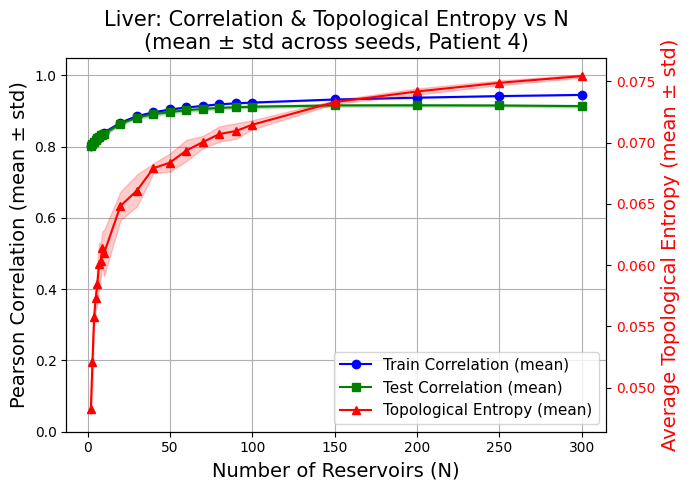

In [4]:
# ====== Load saved results CSV ======
results_csv = f"results_dsrn_patient_{patient_id}/results_summary_patient_{patient_id}_c.csv"
df = pd.read_csv(results_csv)

# ====== Group by N across seeds ======
grouped = df.groupby("N")

N_values = np.array(sorted(df["N"].unique()))

# Mean values
train_corr_mean = grouped["Train_r"].mean().values
test_corr_mean  = grouped["Test_r"].mean().values
entropy_mean    = grouped["Avg_Topological_Entropy"].mean().values

# Std values
train_corr_std = grouped["Train_r"].std().values
test_corr_std  = grouped["Test_r"].std().values
entropy_std    = grouped["Avg_Topological_Entropy"].std().values


# ====== Plot ======
fig, ax1 = plt.subplots(figsize=(7,5))

# ---- Left Y-axis: correlation ----
ax1.set_xlabel("Number of Reservoirs (N)", fontsize=14)
ax1.set_ylabel("Pearson Correlation (mean ± std)", fontsize=14)

# Train correlation
ax1.plot(N_values, train_corr_mean, '-o', color='blue', label='Train Correlation (mean)')
ax1.fill_between(N_values,
                 train_corr_mean - train_corr_std,
                 train_corr_mean + train_corr_std,
                 color='blue', alpha=0.2)

# Test correlation
ax1.plot(N_values, test_corr_mean, '-s', color='green', label='Test Correlation (mean)')
ax1.fill_between(N_values,
                 test_corr_mean - test_corr_std,
                 test_corr_mean + test_corr_std,
                 color='green', alpha=0.2)

ax1.set_ylim(0, 1.05)
ax1.grid(True)


# ---- Right Y-axis: Entropy ----
ax2 = ax1.twinx()
ax2.set_ylabel("Average Topological Entropy (mean ± std)", color='red', fontsize=14)

ax2.plot(N_values, entropy_mean, '-^', color='red', label='Topological Entropy (mean)')
ax2.fill_between(N_values,
                 entropy_mean - entropy_std,
                 entropy_mean + entropy_std,
                 color='red', alpha=0.2)

ax2.tick_params(axis='y', labelcolor='red')

# ---- Combined Legend ----
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
           loc='lower right', fontsize=11)

plt.title(f"Liver: Correlation & Topological Entropy vs N\n(mean ± std across seeds, Patient {patient_id})", fontsize=15)
plt.tight_layout()

plt.savefig(f"liver_corr_vs_topo_mean_std_patient{patient_id}.png", dpi=300, bbox_inches="tight")
plt.show()


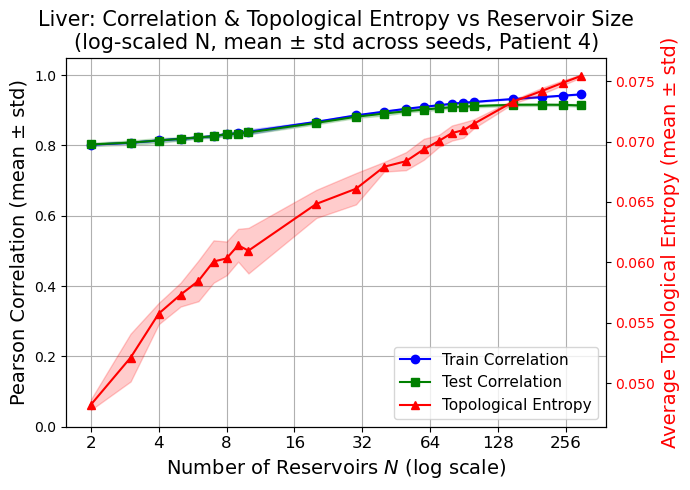

In [2]:
# ====== Load saved results CSV ======
results_csv = f"results_dsrn_patient_{patient_id}/results_summary_patient_{patient_id}_c.csv"
df = pd.read_csv(results_csv)

# ====== Group by N across seeds ======
grouped = df.groupby("N")

# Sort N explicitly
N_values = np.array(sorted(grouped.groups.keys()))
logN = np.log(N_values)

# Mean values
train_corr_mean = grouped["Train_r"].mean().loc[N_values].values
test_corr_mean  = grouped["Test_r"].mean().loc[N_values].values
entropy_mean    = grouped["Avg_Topological_Entropy"].mean().loc[N_values].values

# Std values (replace NaN with 0 if single seed)
train_corr_std = grouped["Train_r"].std().loc[N_values].fillna(0).values
test_corr_std  = grouped["Test_r"].std().loc[N_values].fillna(0).values
entropy_std    = grouped["Avg_Topological_Entropy"].std().loc[N_values].fillna(0).values


# ====== Plot ======
fig, ax1 = plt.subplots(figsize=(7, 5))

# ---- Left Y-axis: correlation ----
ax1.set_xlabel(r"Number of Reservoirs $N$ (log scale)", fontsize=14)
ax1.set_ylabel("Pearson Correlation (mean ± std)", fontsize=14)

# Train correlation (BLUE)
ax1.plot(logN, train_corr_mean, '-o', color='blue', label='Train Correlation')
ax1.fill_between(
    logN,
    train_corr_mean - train_corr_std,
    train_corr_mean + train_corr_std,
    color='blue',
    alpha=0.2
)

# Test correlation (GREEN)
ax1.plot(logN, test_corr_mean, '-s', color='green', label='Test Correlation')
ax1.fill_between(
    logN,
    test_corr_mean - test_corr_std,
    test_corr_mean + test_corr_std,
    color='green',
    alpha=0.2
)

ax1.set_ylim(0, 1.05)
ax1.grid(True)

# ---- Right Y-axis: entropy ----
ax2 = ax1.twinx()
ax2.set_ylabel("Average Topological Entropy (mean ± std)", color='red', fontsize=14)

ax2.plot(logN, entropy_mean, '-^', color='red', label='Topological Entropy')
ax2.fill_between(
    logN,
    entropy_mean - entropy_std,
    entropy_mean + entropy_std,
    color='red',
    alpha=0.2
)

ax2.tick_params(axis='y', labelcolor='red')


# ====== Sparse, readable x-ticks ======
# Option 1: powers of 2 (best for scaling)
tick_N = np.array([2, 4, 8, 16, 32, 64, 128, 256])
tick_N = tick_N[tick_N <= N_values.max()]
tick_logN = np.log(tick_N)

ax1.set_xticks(tick_logN)
ax1.set_xticklabels(tick_N, fontsize=12)


# ---- Combined Legend ----
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc='lower right',
    fontsize=11
)
plt.title(f"Liver: Correlation & Topological Entropy vs Reservoir Size\n(log-scaled N, mean ± std across seeds, Patient {patient_id})", fontsize=15)

plt.tight_layout()
plt.savefig(f"liver_corr_vs_topo_mean_std_patient{patient_id}.jpeg", format='jpeg', dpi=650, bbox_inches="tight")
plt.show()
